<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/Developing-Tool/Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MEDIA BIAS Thesis

# Setting up Environment

## PIP install

In [21]:
!pip3 install requests-html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium

# Install xvfb
apt install -y xvfb

# Install Selenium-Profiles
pip uninstall -y selenium_profiles
pip install --no-cache-dir selenium_profiles>=2.2.6

# pip install https://github.com/kaliiiiiiiiii/Selenium-Profiles/archive/refs/heads/dev.zip # dev-branch

# install python packages
pip install google-colab-shell
pip install webdriver-manager
pip install Pyvirtualdisplay 

Executing: /tmp/apt-key-gpghome.HS6SxDK7E6/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.XItw4tNYPs/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.PnhBgMDre7/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on c

In [24]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import date
from requests_html import HTMLSession 
import re

## Mounting to GDrive

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### dir variable

In [26]:
dir  = "/content/gdrive/MyDrive/THESIS-MS/Git-Thesis22-23/Official/"

# Preperation Scrape

1. GMA7 - infinite scroll with dates
2. ABS CBN (Online) - has mix of Filipino news **
3. CNN Philippines - limited newslink  **
4. Philippine Star -  headline/nation infinite scroll
5. Rappler - by page
6. Manila Bulletin - infinite more button
7. TV5 - single page (?) limited **
8. Manila Standard - limited load more *
9. Sunstar Philippines - pages 
10. Philippine News Agency

## Extract Source Function

In [27]:
def extract_source(url):
    agent = {"User-Agent":"Chrome/105.0.0.0"}
    try:
      source=requests.get(url, headers=agent)
    except Exception as e:                                   # this describes what to do if an exception is thrown
      error_type, error_obj, error_info = sys.exc_info()      # get the exception information
      print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
      print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
    
    return source                                               #ignore this page. Abandon this and go back.

## Chrome driver

In [28]:
# https://colab.research.google.com/github/kaliiiiiiiiii/Selenium-Profiles/blob/master/google-colab/selenium_profiles.ipynb#scrollTo=lThF-0LvpZf3
## @title Start actual driver
from selenium_profiles.webdriver import Chrome
from selenium_profiles.profiles import profiles
from selenium.webdriver.common.by import By  # locate elements
from selenium_profiles.utils.colab_utils import display, showscreen, show_html # virtual display
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementNotVisibleException, ElementNotSelectableException
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

display = display()

def startChromeDriver():
  options = Options()
#   options.add_argument('--disable-blink-features=AutomationControlled')
  chromedriver_path = ChromeDriverManager(version="90.0.4430.24").install()
  profile = profiles.Windows() # or .Android
  profile["cdp"]["cores"] = None # Chrome 90 doesn't allow emulating cores :(driver = mydriver.start(profile, uc_driver=False, executable_path=chromedriver_path)
  mydriver = Chrome(profile, executable_path=chromedriver_path, options=options)
  display.start_display()
  return mydriver.start()
   

# Media Outlet

## ABS CBN *

In [ ]:
## ABS CBN
# pagesToGet= 2
# topic = "Queen Elizabeth Death"
site = "ABS-CBN_NEWS"


data=pd.DataFrame(columns=['Title','Link','Date'])

# for page in range(1,pagesToGet+1):
#   url = 'https://news.abs-cbn.com/special-pages/search?q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)+'#gsc.tab=0&gsc.q='+topic.replace(" ", "%20")+'&gsc.sort=&gsc.page='+str(page)
#   print(url)

#   driver.get(url)
#   # WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.ID, '___gcse_0'))) 
#   source = driver.page_source

#   time.sleep(2)   
#   soup = BeautifulSoup(source, 'html.parser')
#   searches = soup.find_all('div', {'class':'gsc-webResult gsc-result'})
#   filename= f"{dir}{site}-{topic}-NEWS-List.csv"     

#   for x in searches:
#     frame=[]
#     Title = x.find('div', class_="gs-title").find("a").text.strip()
#     Date = x.find('div', class_="gs-bidi-start-align gs-snippet").text[:12].strip()
#     Link = x.find('a', class_="gs-title")['href']
#     frame.extend((Title, Link, Date, topic))

#     data = data.append(pd.Series(frame, index=data.columns[:len(frame)]), ignore_index=True)



# data.to_csv(filename)
# driver.quit()
# data




In [90]:
def abscbnArticleScraper(url):
  print(url)
  driver = startChromeDriver()
  driver.get(url)
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, 'news-title'))) 

  source = driver.page_source
  soup=BeautifulSoup(source, 'html.parser')
  row=[]
 
  Title = soup.find('h1',{'class':'news-title'}).text.strip()
  Author = soup.find('span',attrs={'class':'editor'}).text.strip()
  Date = soup.find('span', attrs={'class': 'date-posted'}).text[:-8].strip() 
  
  textList =soup.find("div", {'class' :'article-content'}).find_all("p")
  body = ""
  for t in textList:
    if (t.text != "RELATED VIDEO:"):
      body += (t.text) +"\n" 

  row.extend((Title, Author, Date, body))
  return row

site='ABS-CBN'
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

row = abscbnArticleScraper('https://news.abs-cbn.com/news/05/05/23/ph-airspace-shutdown-on-may-17-shortened-to-2-hours')
data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)

  
data2.to_csv(filename)
data2.head()

https://news.abs-cbn.com/news/05/05/23/ph-airspace-shutdown-on-may-17-shortened-to-2-hours


,Title,Author,Date,Text
0,Philippine airspace shutdown on May 17 shorten...,ABS-CBN News,May 05 2023,Philippine airspace shutdown on May 17 shorten...


## CNN Philippines *

In [ ]:
site = "CNN-Philippines"
data=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://www.cnnphilippines.com/news/'
print(url)

# driver = startChromeDriver()
# driver.get(url)
# driver.implicitly_wait(10)

# source = driver.page_source
# soup = BeautifulSoup(source, 'html.parser')

# linksCarousel = soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story left-grid'})
# linksRow = soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story right-grid'})
# links = linksCarousel + linksRow
# print(len(links))

# filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

# for j in links:
#     Statement = j.find('div').find('div', {'class': 'story'}).find('div', {'class': 'story_title_holder'}).find('div', {'class' : 'story_title'}).text[:-21].strip()
#     Link = j.find('a')['href'].strip()
#     Date = j.find('div', {'class' : 'story_title_holder'}).find('div', {'class' : 'story_title'}).find('div', {'class': 'archive_date_time'}).text[:-8].strip()
#     df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
#     print(Statement, Link, Date)
#     data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

# driver.quit()
# data.to_csv(filename)
# data.head()

# owl-pagination

In [ ]:
def cnnArticleScraper(url):
  print(url)
  driver = startChromeDriver()
  driver.get(url)
  WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.CLASS_NAME, 'title'))) 
  source = driver.page_source
  soup=BeautifulSoup(source, 'html.parser')
  row=[]
  try: 
    Title = soup.find('h1',{'class':'title'}).text.strip()
    Author = soup.find('div',attrs={'class':'author-byline'}).find('p').find('a').text.strip()
    Date = soup.find('div', attrs={'class': 'dateLine'}).find('p', {'class': 'dateString no-icon'}).text[10:-12].strip() 
    textList =soup.find("div", {'class' :'article-maincontent-p cnn-life-body'}).find_all("p")
    body = ""
    for t in textList:
        if (t.text != "ADVERTISEMENT"):
          body += (t.text) +"\n" 
    row.extend((Title, Author, Date, body))
  except AttributeError:
    pass
  driver.quit()
  return row

site = "CNN-Philippines"
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

row = cnnArticleScraper('https://www.cnnphilippines.com/news/2023/5/4/MIAA-possible-extension-of-May-17-airspace-shutdown.html')
data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2.head()

https://www.cnnphilippines.com/news/2023/5/4/MIAA-possible-extension-of-May-17-airspace-shutdown.html


,Title,Author,Date,Text
0,MIAA prepares for possible extension of 6-hour...,CNN Philippines Staff,"May 4, 2023,","Metro Manila (CNN Philippines, May 4) — The Ma..."


In [ ]:
print(BeautifulSoup(extract_source('https://www.cnnphilippines.com/news/2023/5/4/us-backs-ph-south-china-sea.html').text, 'html.parser').prettify())

## Philippine Star *

https://www.philstar.com/headlines/
scrolling...
scrolling...


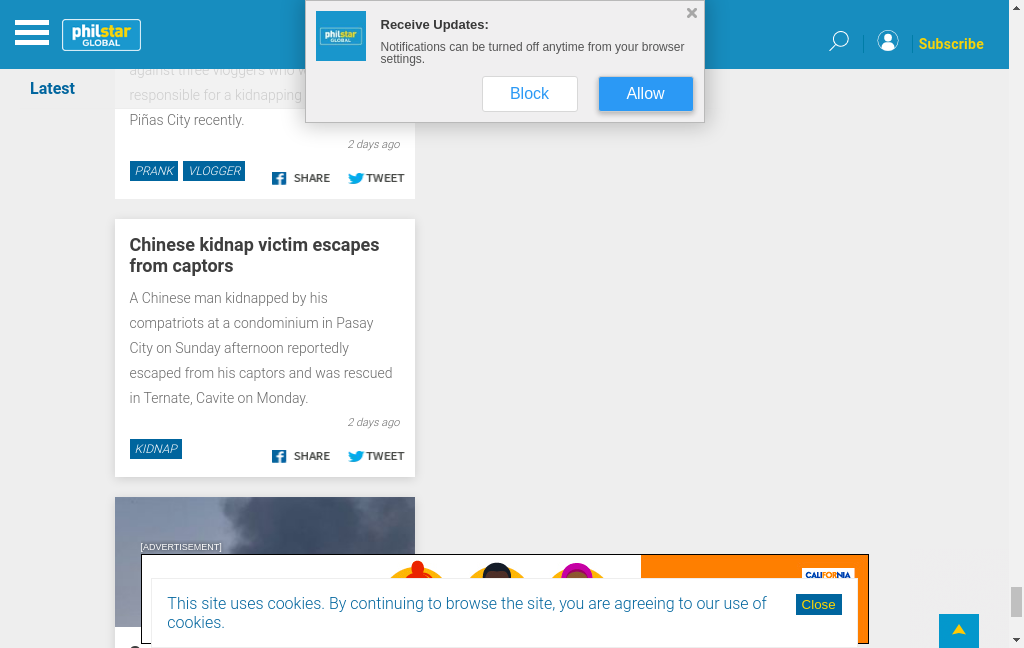

help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutException'> Line: 61
help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutException'> Line: 61
help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutException'> Line: 61
help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutException'> Line: 61
help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutException'> Line: 61
help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutException'> Line: 61
help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutException'> Line: 61
help!!!!!!!
ERROR FOR LINK: https://www.philstar.com/headlines/
<class 'selenium.common.exceptions.TimeoutExcep

,Statement,Link,Date
0,Comelec seeks budget for hybrid count machines,https://www.philstar.com/headlines/2023/05/05/...,1 hour ago
1,"Philippines, US to increase tempo of sea activ...",https://www.philstar.com/headlines/2023/05/05/...,1 hour ago
2,Airlines ready for May 17 airspace closure,https://www.philstar.com/headlines/2023/05/05/...,1 hour ago
3,Two DepEd admin officials resign; Ablan says q...,https://www.philstar.com/headlines/2023/05/04/...,1 hour ago
4,42% want ROTC to be optional – SWS,https://www.philstar.com/headlines/2023/05/05/...,1 hour ago
5,"UP Baguio, Cebu suspend face-to-face classes d...",https://www.philstar.com/headlines/2023/05/04/...,\nBy Janvic Mateo | 1 day ago
6,"2 police generals, 2 colonels recommended for ...",https://www.philstar.com/headlines/2023/05/03/...,\nBy Emmanuel Tupas | 2 days ago
7,Over 150 Filipinos evacuated from Sudan to arr...,https://www.philstar.com/headlines/2023/05/02/...,\n2 days ago
8,DILG identifies alternative fishing sites for ...,https://www.philstar.com/headlines/2023/05/04/...,\nBy Gaea Katreena Cabico | 9 hours ago
9,Government printer to produce driver’s license...,https://www.philstar.com/headlines/2023/05/04/...,\nBy Bella Cariaso | 1 day ago


In [ ]:
# https://www.philstar.com/headlines
# https://www.philstar.com/nation˛

site = "PhilStar"
data=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://www.philstar.com/headlines/'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)
counter = 2
try:
  SCROLL_PAUSE_TIME = 1
  cnt = counter
  # Get scroll height
  last_height = driver.execute_script("return document.body.scrollHeight")
  while cnt>0:
      # Scroll down to bottom
      driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
      # Wait to load page
      time.sleep(SCROLL_PAUSE_TIME)
      # Calculate new scroll height and compare with last scroll height
      new_height = driver.execute_script("return document.body.scrollHeight")
      if new_height == last_height:
          break
      last_height = new_height
      print("scrolling...")
    #   showscreen(driver)
      cnt -= 1
except Exception as e:                                   
  error_type, error_obj, error_info = sys.exc_info()      
  print ('ERROR FOR LINK:',url)                          
  print (error_type, 'Line:', error_info.tb_lineno)  

try:
  WebDriverWait(driver, timeout=30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'theContent')))
  source = driver.page_source
  soup = BeautifulSoup(source, 'html.parser')
  linksCarousel  = soup.find('div', {'class':'carousel__items'}).find_all('div', {'class' : 'carousel__item__title'})
  
  WebDriverWait(driver, timeout=30).until(EC.presence_of_element_located((By.ID, 'news_main')))
  WebDriverWait(driver, timeout=60).until(EC.visibility_of_element_located((By.CLASS_NAME, 'jscroll-inner')))

  links1 = []
  links1 += soup.find('div', {'id':'news_main'}).find('div', {'class' : 'news_column trending'}).find_all('div', {'class':'tiles trend'}) 
  links1 += soup.find('div', {'id':'news_main'}).find('div', {'class' : 'news_column latest'}).find_all('div', {'class':'tiles late'}) 
  links2 = []

  if (counter >1):
    WebDriverWait(driver, timeout=60).until(EC.visibility_of_element_located((By.CLASS_NAME, 'jscroll-added')))
    linksAddJScroll = soup.find('div', {'id':'news_main'}).find_all('div', {'class':'jscroll-added'})
    # showscreen(driver)
    
    for x in linksAddJScroll:
        try:
            # js_code = "arguments[0].scrollIntoView();"
            # # //*[@id="news_main"]/div/div[6]/div[2]
            # element = WebDriverWait(driver, timeout=5).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="news_main"]/div/div[6]/div[2]')))
            time.sleep(2)
            WebDriverWait(driver, timeout=30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'news_column trending')))
            links2 += x.find('div', {'class' : 'news_column trending'}).find_all('div', attrs={'class': re.compile('^tiles trend')})
            links2 += x.find('div', {'class' : 'news_column latest'}).find_all('div', attrs={'class': re.compile('^tiles late')})
        except:
            print('help!!!!!!!')
            error_type, error_obj, error_info = sys.exc_info()      
            print ('ERROR FOR LINK:',url)                          
            print (error_type, 'Line:', error_info.tb_lineno) 

    

#   showscreen(driver)
#   print(linksTrending,linksLatest)
except Exception as e:                                   
  error_type, error_obj, error_info = sys.exc_info()      
  print ('ERROR FOR LINK:',url)                          
  print (error_type, 'Line:', error_info.tb_lineno) 

print(len(linksCarousel)+len(links1)+len(links2))

for j in linksCarousel:
    Statement = j.find('h2').find('a').text.strip()
    Link = j.find('a')['href'].strip()
    Date = soup.find('div', {'class':'carousel__items'}).find('div', {'class' : 'carousel__item__time'}).text
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    print('car',Statement, Link, Date)
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

for j in links1:
    Statement = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'news_title'}).find('h2').find('a').text.strip()
    Link = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'news_title'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'dateOfFeature'}).text
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    print('li',Statement, Link, Date)
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

for j in links2:
    Statement = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'news_title'}).find('a').text.strip()
    Link = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'news_title'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'TilesText spec'}).find('div', {'class':'dateOfFeature'}).text
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    print('li2',Statement, Link, Date)
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

display.stop_display()
driver.quit()

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"   
data.to_csv(filename)
data

In [ ]:
def philStarArticleScraper(url):
  print(url)
  row=[]

  try: 
    driver = startChromeDriver()
    driver.get(url)
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'article__title'))) 
    source = driver.page_source
    soup=BeautifulSoup(source, 'html.parser')

    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.ID, 'sports_article_writeup'))) 
    Title = soup.find('div',{'class':'article__title'}).find('h1').text.strip()
    Author = soup.find('div', attrs={'class': 'article__credits'}).find('div',attrs={'class':'article__credits-author-pub'}).text.strip()
    Date = soup.find('div', attrs={'class': 'article__credits'}).find('div', {'class': 'article__date-published'}).text[:-11].strip() 
    textList =soup.find("div", {'class' :'article__writeup'}).find_all("p")
    body = ""
    for t in textList:
        body += (t.text) +"\n" 
    row.extend((Title, Author, Date, body))
    
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
  driver.quit()
  return row

site = "PhilStar"
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

for index, row in data.iterrows():
  url = row["Link"] 
  row = philStarArticleScraper(url)
  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2

https://www.philstar.com/headlines/2023/05/05/2263946/comelec-seeks-budget-hybrid-count-machines
https://www.philstar.com/headlines/2023/05/05/2263943/philippines-us-increase-tempo-sea-activities
https://www.philstar.com/headlines/2023/05/05/2263939/airlines-ready-may-17-airspace-closure
https://www.philstar.com/headlines/2023/05/04/2263761/two-deped-admin-officials-resign-ablan-says-quitting-not-related-laptops-controversy
https://www.philstar.com/headlines/2023/05/05/2263935/42-want-rotc-be-optional-sws
https://www.philstar.com/headlines/2023/05/04/2263627/baguio-cebu-suspend-face-face-classes-due-covid-19
https://www.philstar.com/headlines/2023/05/03/2263348/2-police-generals-2-colonels-recommended-drug-raps
https://www.philstar.com/headlines/2023/05/02/2263253/over-150-filipinos-evacuated-sudan-arrive-may-4
https://www.philstar.com/headlines/2023/05/04/2263763/dilg-identifies-alternative-fishing-sites-oriental-mindoro-fishers
https://www.philstar.com/headlines/2023/05/04/2263655/go

,Title,Author,Date,Text
0,Comelec seeks budget for hybrid count machines,Evelyn Macairan - The Philippine Star This con...,"May 5, 202","MANILA, Philippines — To prevent a repeat of m..."
1,"Philippines, US to increase tempo of sea activ...",Alexis Romero - The Philippine Star This conte...,"May 5, 202",WASHINGTON – The Philippines has agreed to an ...
2,Airlines ready for May 17 airspace closure,Elijah Felice Rosales - The Philippine Star Th...,"May 5, 202","MANILA, Philippines — Airlines have started re..."
3,Two DepEd admin officials resign; Ablan says q...,Cristina Chi - Philstar.com,"May 4, 20","MANILA, Philippines — Two Department of Educat..."
4,42% want ROTC to be optional – SWS,Janvic Mateo - The Philippine Star This conten...,"May 5, 202","MANILA, Philippines — More Filipinos prefer an..."
5,"UP Baguio, Cebu suspend face-to-face classes d...",Janvic Mateo - The Philippine Star This conten...,"May 4, 202","MANILA, Philippines — The University of the Ph..."
6,"2 police generals, 2 colonels recommended for ...",Emmanuel Tupas - The Philippine Star This cont...,"May 3, 202","MANILA, Philippines — Four ranking police offi..."
7,Over 150 Filipinos evacuated from Sudan to arr...,Philstar.com,"May 2, 20","MANILA, Philippines — More Filipinos who were ..."
8,DILG identifies alternative fishing sites for ...,Gaea Katreena Cabico - Philstar.com,"May 4, 20","MANILA, Philippines — The Department of the In..."
9,Government printer to produce driver’s license...,Bella Cariaso - The Philippine Star This conte...,"May 4, 202","MANILA, Philippines — To speed up the release ..."


## TV5


In [86]:
# https://news.tv5.com.ph/articles/politics

site = "TV5"
data=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://news.tv5.com.ph/articles/politics'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)

WebDriverWait(driver, timeout=30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'col-md-8')))
WebDriverWait(driver, timeout=5).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="grid-cat"]/div[2]')))

source = driver.page_source
time.sleep(2)
soup = BeautifulSoup(source, 'html.parser')

links = soup.find('div',{'class':'col-md-8'}).find_all('a')
print(len(links))

for j in links:
    Statement = j.find('div', {'class' : 'title'}).text.strip()
    Link = j['href'].strip()
    Date = j.find('div', {'class': 'date'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
data.head()

https://news.tv5.com.ph/articles/politics
50


,Statement,Link,Date
0,RUTHLESS APPROACH | Marcos says Duterte’s drug...,https://news.tv5.com.ph/politics/read/ruthless...,"May 5, 2023 , 10:34 AM"
1,MARITIME DISPUTE | U.S. issues guidelines on d...,https://news.tv5.com.ph/politics/read/maritime...,"May 4, 2023 , 07:30 PM"
2,‘BROADER UNDERSTANDING’ | Same-sex union part ...,https://news.tv5.com.ph/politics/read/broader-...,"May 4, 2023 , 10:29 AM"
3,SERIOUS ALLEGATION | Russia says Ukraine tried...,https://news.tv5.com.ph/politics/read/serious-...,"May 4, 2023 , 09:38 AM"
4,WEST PHILIPPINE SEA | US stands with Philippin...,https://news.tv5.com.ph/politics/read/west-phi...,"May 3, 2023 , 09:49 PM"


In [87]:
# https://news.tv5.com.ph/articles/national

site = "TV5"
url = 'https://news.tv5.com.ph/articles/national'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)

WebDriverWait(driver, timeout=30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'col-md-8')))
WebDriverWait(driver, timeout=5).until(EC.visibility_of_element_located((By.XPATH, '//*[@id="grid-cat"]/div[2]')))

source = driver.page_source
time.sleep(2)
soup = BeautifulSoup(source, 'html.parser')

links = soup.find('div',{'class':'col-md-8'}).find_all('a')
print(len(links))

for j in links:
    Statement = j.find('div', {'class' : 'title'}).text.strip()
    Link = j['href'].strip()
    Date = j.find('div', {'class': 'date'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    
data.to_csv(filename)
data.head()

https://news.tv5.com.ph/articles/national
50


,Statement,Link,Date
0,RUTHLESS APPROACH | Marcos says Duterte’s drug...,https://news.tv5.com.ph/politics/read/ruthless...,"May 5, 2023 , 10:34 AM"
1,MARITIME DISPUTE | U.S. issues guidelines on d...,https://news.tv5.com.ph/politics/read/maritime...,"May 4, 2023 , 07:30 PM"
2,‘BROADER UNDERSTANDING’ | Same-sex union part ...,https://news.tv5.com.ph/politics/read/broader-...,"May 4, 2023 , 10:29 AM"
3,SERIOUS ALLEGATION | Russia says Ukraine tried...,https://news.tv5.com.ph/politics/read/serious-...,"May 4, 2023 , 09:38 AM"
4,WEST PHILIPPINE SEA | US stands with Philippin...,https://news.tv5.com.ph/politics/read/west-phi...,"May 3, 2023 , 09:49 PM"


In [91]:
# preprocess TV text in future
def tv5ArticleScraper(url):
  print(url)
  row=[]

  try: 
    driver = startChromeDriver()
    driver.get(url)
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'post-title'))) 
    source = driver.page_source
    soup=BeautifulSoup(source, 'html.parser')

    Title = soup.find('div',{'class':'post-title'}).text.strip()
    try:
        Author = soup.find('em').text.strip()
    except AttributeError:
        Author = ""
    try:
        Date = soup.find('div' , {'class', 'post-postdata'}).text[:-10].strip() 
    except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
      Date = ""
      
    textList =soup.find("div", {'class' :'post-cont'}).find_all("p")
    body = ""
    for t in textList:
        body += (t.text) +"\n" 
    row.extend((Title, Author, Date, body))
    
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
  driver.quit()
  return row

site = "TV5"
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

for index, r in data.iterrows():
  url = r["Link"] 
  row = tv5ArticleScraper(url)
  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  if index ==10:
      break
 
data2.to_csv(filename)
data2

https://news.tv5.com.ph/politics/read/ruthless-approach-marcos-says-dutertes-drug-war-had-abuses
https://news.tv5.com.ph/politics/read/maritime-dispute-u-s-issues-guidelines-on-defending-philippines-from-south-china-sea-attack
https://news.tv5.com.ph/politics/read/broader-understanding-same-sex-union-part-of-curriculum-since-2013-says-deped
https://news.tv5.com.ph/politics/read/serious-allegation-russia-says-ukraine-tried-to-kill-putin-with-night-time-drone-attack
https://news.tv5.com.ph/politics/read/west-philippine-sea-us-stands-with-philippines-against-chinese-intimidation-in-s-china-sea-official
https://news.tv5.com.ph/politics/read/true-friendship-marcos-cites-need-to-continually-revisit-trade-ties-between-philippines-us
https://news.tv5.com.ph/politics/read/us-philippine-ties-amid-china-pressure-us-and-philippines-recommit-to-security-alliance
https://news.tv5.com.ph/politics/read/direct-line-philippines-china-to-discuss-fishing-rights-in-south-china-sea-says-marcos
https://news.

,Title,Author,Date,Text
0,RUTHLESS APPROACH | Marcos says Duterte’s drug...,By Beatrice Puente,"May 5, 2023 ,","By Beatrice Puente\n(May 5, 2023) – President ..."
1,MARITIME DISPUTE | U.S. issues guidelines on d...,By Karen Lema,"May 4, 2023 ,","By Karen Lema\nMANILA, May 4 (Reuters) – The U..."
2,‘BROADER UNDERSTANDING’ | Same-sex union part ...,By Beatrice Puente,"May 4, 2023 ,","By Beatrice Puente\n(May 4, 2023) – The Depart..."
3,SERIOUS ALLEGATION | Russia says Ukraine tried...,(Additional reporting by Felix Light and Jake ...,"May 4, 2023 ,",By Mark Trevelyan\nMay 3 (Reuters) – Russia ac...
4,WEST PHILIPPINE SEA | US stands with Philippin...,By Karen Lema,"May 3, 2023 ,",By Karen Lema\nMay 3 (Reuters) – The United St...
5,‘TRUE FRIENDSHIP’ | Marcos cites need to ‘cont...,By Beatrice Puente,"May 3, 2023 ,","By Beatrice Puente\n(May 3, 2023) – President ..."
6,"US-PHILIPPINE TIES | Amid China pressure, US a...","By Jeff Mason, Trevor Hunnicutt and David Brun...","May 2, 2023 ,","By Jeff Mason, Trevor Hunnicutt and David Brun..."
7,"DIRECT LINE | Philippines, China to discuss fi...",(Reporting by Enrico Dela Cruz; Editing by Ale...,"May 2, 2023 ,","MANILA, May 1 (Reuters) – Philippines Presiden..."
8,DEFENSE POSTURE | Marcos’ US visit strategic t...,By Beatrice Puente,"May 2, 2023 ,","By Beatrice Puente\n(May 2, 2023) – President ..."
9,"IRONCLAD TIES | US, Philippines recommit to se...",(Reporting by Trevor Hunnicutt and David Brunn...,"May 2, 2023 ,","By Jeff Mason, Trevor Hunnicutt and David Brun..."


## Manila Standard


In [47]:
# https://manilastandard.net/category/news/national

site = "Manila Standard"
data=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://manilastandard.net/category/news/national'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(30)

source = driver.page_source

time.sleep(3)
soup = BeautifulSoup(source, 'html.parser')

links = soup.find('div',{'class':'jeg_hero_wrapper'}).find_all('div',attrs={'class':'jeg_postblock_content'})

try:
    js_code = "arguments[0].scrollIntoView();"
    # The WebElement you want to scroll to
    element = WebDriverWait(driver, timeout=5).until(EC.visibility_of_element_located((By.XPATH, '/html/body/div[2]/div[5]/div/div[1]/div[2]/div/div[4]/div[1]/div/div[1]/div/h1')))
    # Execute the JS script
    driver.execute_script(js_code, element)
    time.sleep(2)  
except Exception as e:                                   
    error_type, error_obj, error_info = sys.exc_info()      
    print ('ERROR FOR LINK:',url)                          
    print (error_type, 'Line:', error_info.tb_lineno) 

linksPOST = soup.find('div', {'class':'jeg_main_content jeg_column col-sm-8'}).find_all('div',attrs={'class':'jeg_postblock_content'})

print(len(links)+len(linksPOST))

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

for j in links:
    Statement = j.find('h2', {'class' : 'jeg_post_title'}).find('a').text.strip()
    Link = j.find('h2', {'class' : 'jeg_post_title'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'jeg_meta_date'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

for j in linksPOST:
    Statement = j.find('h3', {'class' : 'jeg_post_title'}).find('a').text.strip()
    Link = j.find('h3', {'class' : 'jeg_post_title'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'jeg_meta_date'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
data.head()

https://manilastandard.net/category/news/national
15


,Statement,Link,Date
0,US firms keen on hiring Pinoy workers from Sudan,https://manilastandard.net/news/national/31432...,"May 5, 2023, 12:30 am"
1,DICT to launch SIM Check to fight scammers,https://manilastandard.net/news/national/31432...,"May 5, 2023, 12:25 am"
2,PNP to implement cigarette and vape ban among ...,https://manilastandard.net/news/national/31432...,"May 5, 2023, 12:20 am"
3,More people think ROTC should be optional than...,https://manilastandard.net/news/national/31432...,"May 4, 2023, 11:30 pm"
4,PNP prioritizes cases of missing ‘sabungeros ‘,https://manilastandard.net/news/314327726/pnp-...,"May 4, 2023, 11:20 pm"


In [49]:
# https://manilastandard.net/category/news/top-stories

site = "Manila Standard"
url = 'https://manilastandard.net/category/news/top-stories'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)

source = driver.page_source
time.sleep(3)
soup = BeautifulSoup(source, 'html.parser')

links = soup.find('div',{'class':'jeg_hero_wrapper'}).find_all('div',attrs={'class':'jeg_postblock_content'})

try:
    js_code = "arguments[0].scrollIntoView();"
    # The WebElement you want to scroll to
    element = WebDriverWait(driver, timeout=5).until(EC.element_to_be_clickable((By.XPATH, '/html/body/div[2]/div[5]/div/div[1]/div[2]/div/div[4]/div[1]/div/div[1]/div/h1')))
    # Execute the JS script
    driver.execute_script(js_code, element)
    time.sleep(2)  
except Exception as e:                                   
    error_type, error_obj, error_info = sys.exc_info()      
    print ('ERROR FOR LINK:',url)                          
    print (error_type, 'Line:', error_info.tb_lineno) 

linksPOST = soup.find('div', {'class':'jeg_main_content jeg_column col-sm-8'}).find_all('div',attrs={'class':'jeg_postblock_content'})

print(len(links)+len(linksPOST))

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

for j in links:
    Statement = j.find('h2', {'class' : 'jeg_post_title'}).find('a').text.strip()
    Link = j.find('h2', {'class' : 'jeg_post_title'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'jeg_meta_date'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)

for j in linksPOST:
    Statement = j.find('h3', {'class' : 'jeg_post_title'}).find('a').text.strip()
    Link = j.find('h3', {'class' : 'jeg_post_title'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'jeg_meta_date'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    data = data.append(pd.Series(df_new_row, index=data.columns[:len(df_new_row)]), ignore_index=True)


driver.quit()
data.head()

https://manilastandard.net/category/news/top-stories
15


,Statement,Link,Date
0,US firms keen on hiring Pinoy workers from Sudan,https://manilastandard.net/news/national/31432...,"May 5, 2023, 12:30 am"
1,DICT to launch SIM Check to fight scammers,https://manilastandard.net/news/national/31432...,"May 5, 2023, 12:25 am"
2,PNP to implement cigarette and vape ban among ...,https://manilastandard.net/news/national/31432...,"May 5, 2023, 12:20 am"
3,More people think ROTC should be optional than...,https://manilastandard.net/news/national/31432...,"May 4, 2023, 11:30 pm"
4,PNP prioritizes cases of missing ‘sabungeros ‘,https://manilastandard.net/news/314327726/pnp-...,"May 4, 2023, 11:20 pm"


In [58]:
filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    
data.to_csv(filename)

In [59]:
def manilaStandardArticleScraper(url):
  print(url)
  row=[]
  try: 
    driver = startChromeDriver()
    driver.get(url)
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'jeg_post_title'))) 
    source = driver.page_source
    soup=BeautifulSoup(source, 'html.parser')

    
    Title = soup.find('h1',{'class':'jeg_post_title'}).text.strip()
    try:
        Author = soup.find('div', attrs={'class': 'jeg_meta_author coauthor'}).text.strip()
    except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
      Author = ""
        
    try:
        Date = soup.find('div', {'class' :'jeg_meta_date'}).text[:-10].strip() 
    except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
      Date = ""
    time.sleep(3)
    textList =soup.find('div',{'class':'content-inner'}).find_all("p")
    body = ""
    for t in textList:
        body += (t.text) +"\n" 
    row.extend((Title, Author, Date, body))
    
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
  driver.quit()
  return row

site = "Manila Standard"
data2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

for index, r in data.iterrows():
  url = r["Link"] 
  row = manilaStandardArticleScraper(url)
  data2 = data2.append(pd.Series(row, index=data2.columns[:len(row)]), ignore_index=True)
  
data2.to_csv(filename)
data2

https://manilastandard.net/news/national/314327780/us-firms-keen-on-hiring-pinoy-workers-from-sudan.html
https://manilastandard.net/news/national/314327760/dict-to-launch-sim-check-to-fight-scammers.html
https://manilastandard.net/news/national/314327777/pnp-to-implement-cigarette-and-vape-ban-among-minors.html
https://manilastandard.net/news/national/314327728/more-people-think-rotc-should-be-optional-than-compulsory-sws.html
https://manilastandard.net/news/314327726/pnp-prioritizes-cases-of-missing-sabungeros.html
https://manilastandard.net/news/314327724/kadiwa-stores-post-over-p6-4m-sales-nationwide.html
https://manilastandard.net/news/national/314327719/exigency-plans-readied-for-mindoro-fishermen.html
https://manilastandard.net/news/national/314327763/ao-creates-independence-day-panel.html
https://manilastandard.net/news/314327752/comelec-disqualifies-legazpi-mayor-carmen-rosal.html
https://manilastandard.net/news/national/314327750/tolentino-wants-probe-on-govt-plans-vs-avian-fl

,Title,Author,Date,Text
0,US firms keen on hiring Pinoy workers from Sudan,byManila Standard,"May 5, 2023,",American companies have expressed interest in ...
1,DICT to launch SIM Check to fight scammers,byOrlan L. Mauricio,"May 5, 2023,",The Department of Information and Communicatio...
2,PNP to implement cigarette and vape ban among ...,byCharles Dantes,"May 5, 2023,",The Philippine National Police on Thursday ann...
3,More people think ROTC should be optional than...,byVito Barcelo,"May 4, 2023,",More Filipinos think that the Reserve Officers...
4,PNP prioritizes cases of missing ‘sabungeros ‘,byCharles Dantes,"May 4, 2023,",The Philippine National Police (PNP) has given...
5,Kadiwa stores post over P6.4m sales nationwide,byManila Standard,"May 4, 2023,",The government-run Kadiwa stores have generate...
6,Exigency plans readied for Mindoro fishermen,byJoel E. Zurbano,"May 4, 2023,",The Department of the Interior and Local Gover...
7,AO creates Independence Day panel,byVince Lopez,"May 4, 2023,",President Ferdinand Marcos Jr. has signed an a...
8,Comelec disqualifies Legazpi Mayor Carmen Rosal,byVito Barcelo,"May 4, 2023,",The Commission on Elections (Comelec) en banc ...
9,Tolentino wants probe on gov’t plans vs. avian...,byMacon Ramos-Araneta,"May 4, 2023,",Sen. Francis Tolentino wants a Senate probe on...


# MAIN Application

## GMA 

### site scraper

In [104]:
# https://www.gmanetwork.com/news/archives/news-nation
#  https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python
site = "GMA"
gmadata=pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://www.gmanetwork.com/news/archives/news-nation/'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)

try:
  SCROLL_PAUSE_TIME = 0.5
  cnt = 220
  # Get scroll height
  last_height = driver.execute_script("return document.body.scrollHeight")
  while cnt>0:
      # Scroll down to bottom
      driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
      # Wait to load page
      time.sleep(SCROLL_PAUSE_TIME)
      # Calculate new scroll height and compare with last scroll height
      new_height = driver.execute_script("return document.body.scrollHeight")
      if new_height == last_height:
          break
      last_height = new_height
      print('scrolling', cnt)
      cnt -= 1
      time.sleep(1)
except Exception as e:                                   
  error_type, error_obj, error_info = sys.exc_info()      
  print ('ERROR FOR LINK:',url)                          
  print (error_type, 'Line:', error_info.tb_lineno)  

time.sleep(1)
source = driver.page_source
soup = BeautifulSoup(source, 'html.parser')

linksL=soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story left-grid'})
linksR=soup.find("ul", {'id' : 'grid_thumbnail_stories'}).find_all('li', {'class':'story right-grid'})
links = linksL + linksR
print(len(links))

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

for j in links:
    Statement = j.find('div').find('div', {'class': 'story'}).find('div', {'class': 'story_title_holder'}).find('div', {'class' : 'story_title'}).text[:-21].strip()
    Link = j.find('a')['href'].strip()
    Date = j.find('div', {'class' : 'story_title_holder'}).find('div', {'class' : 'story_title'}).find('div', {'class': 'archive_date_time'}).text[:-8].strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    gmadata = gmadata.append(pd.Series(df_new_row, index=gmadata.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
gmadata.drop_duplicates(inplace=True)
gmadata.to_csv(filename)
gmadata.head()

https://www.gmanetwork.com/news/archives/news-nation/
22
Over 4,000 motorcycle road crashes recorded from January to April, PNP-HPG says https://www.gmanetwork.com/news/topstories/nation/869085/over-4-000-motorcycle-road-crashes-recorded-from-january-to-april-pnp-hpg-says/story/ May 05, 2023
CAAP shortens May 17 air traffic management system maintenance to 2 hours https://www.gmanetwork.com/news/topstories/nation/869080/caap-shortens-may-17-air-traffic-management-system-maintenance-to-2-hours/story/ May 05, 2023
75 PDLs with mild symptoms remain in isolation — BuCor https://www.gmanetwork.com/news/topstories/nation/869077/75-pdls-with-mild-symptoms-remain-in-isolation-bucor/story/ May 05, 2023
Marcos says disengagement with China 'not an option' https://www.gmanetwork.com/news/topstories/nation/869067/marcos-says-disengagement-with-china-not-an-option/story/ May 05, 2023
Marcos to meet with British PM on the sidelines of King Charles III coronation https://www.gmanetwork.com/news/topst

,Statement,Link,Date
0,"Over 4,000 motorcycle road crashes recorded fr...",https://www.gmanetwork.com/news/topstories/nat...,"May 05, 2023"
1,CAAP shortens May 17 air traffic management sy...,https://www.gmanetwork.com/news/topstories/nat...,"May 05, 2023"
2,75 PDLs with mild symptoms remain in isolation...,https://www.gmanetwork.com/news/topstories/nat...,"May 05, 2023"
3,Marcos says disengagement with China 'not an o...,https://www.gmanetwork.com/news/topstories/nat...,"May 05, 2023"
4,Marcos to meet with British PM on the sideline...,https://www.gmanetwork.com/news/topstories/nat...,"May 05, 2023"


In [ ]:
gmadata.shape

### artricle scraper

In [105]:
def gmaArticleScraper(url):
    try: 
        driver = startChromeDriver()
        driver.get(url)
        WebDriverWait(driver, timeout=30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'upper_article'))) 
        source = driver.page_source
        soup=BeautifulSoup(source, 'html.parser')

        row=[]
        try: 
            Title = soup.find('h1',{'class':'story_links'}).text.strip()
            Author = soup.find('div',attrs={'class':'main-byline'}).find('div').find('div').text.strip()
            Date = soup.find('div', attrs={'class': 'article-time'}).find('time')['datetime'][:10].strip() 
            textList =soup.find("div", {'class' :'story_main'}).find_all("p")
            body = ""
            for t in textList:
                if (t.find('p', class_="ad")):
                    pass
                else:
                    body += (t.text) +"\n" 
            row.extend((Title, Author, Date, body))
        except AttributeError:
            pass

    except Exception as e:                                   
        error_type, error_obj, error_info = sys.exc_info()      
        print ('ERROR FOR LINK:',url)                          
        print (error_type, 'Line:', error_info.tb_lineno)
    driver.quit()
    return row

site = "GMA"
gmadata2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

for index, r in gmadata.iterrows():
  url = r["Link"] 
  print(index, url)
  row = gmaArticleScraper(url)
  gmadata2 = gmadata2.append(pd.Series(row, index=gmadata2.columns[:len(row)]), ignore_index=True)
  
gmadata2.to_csv(filename)
gmadata2.head()

,Title,Author,Date,Text
0,"Over 4,000 motorcycle road crashes recorded fr...","By JOVILAND RITA, GMA Integrated News",2023-05-05,Philippine National Police - Highway Patrol G...
1,CAAP shortens May 17 air traffic management sy...,"By TED CORDERO, GMA Integrated News",2023-05-05,The Civil Aviation Authority of the Philippin...
2,75 PDLs with mild symptoms remain in isolation...,By GMA Integrated News,2023-05-05,A total of 75 persons deprived of liberty (PD...
3,Marcos says disengagement with China 'not an o...,"By ANNA FELICIA BAJO, GMA Integrated News",2023-05-05,"WASHINGTON — President Ferdinand ""Bongbong"" M..."
4,Marcos to meet with British PM on the sideline...,"By ANNA FELICIA BAJO, GMA Integrated News",2023-05-05,"WASHINGTON — President Ferdinand ""Bongbong"" M..."


## Rappler

### site scraper

In [ ]:
# https://www.rappler.com/nation/national-news/
site = "Rappler"
rapplerData=pd.DataFrame(columns=['Statement','Link','Date'])

pagesToGet= 550
for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.rappler.com/nation/national-news/page/'+str(page)+'/'
    print(url)
    driver = startChromeDriver()
    driver.get(url)
    driver.implicitly_wait(10)

    source = driver.page_source
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'post-card__more')))
    soup = BeautifulSoup(source, 'html.parser')
    links = soup.find_all('div',attrs={'class':'post-card__more-secondary-story'})
    print(len(links))

    filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

    for j in links:
        Statement = j.find('h3', {'class' : 'post-card__title'}).find('a').text.strip()
        Link = j.find("h3", {'class' : 'post-card__title'}).find('a')['href'].strip()
        Date = j.find('time')['datetime'][:10].strip()
        df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
        rapplerData = rapplerData.append(pd.Series(df_new_row, index=rapplerData.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
rapplerData.drop_duplicates(inplace=True)
rapplerData.to_csv(filename)
rapplerData.head()

processing page : 1
https://www.rappler.com/nation/national-news/page/1/
5
processing page : 2
https://www.rappler.com/nation/national-news/page/2/
4
processing page : 3
https://www.rappler.com/nation/national-news/page/3/
4


,Statement,Link,Date
0,"Elections 2025: Stamping pens, new machine typ...",https://www.rappler.com/nation/comelec-wish-li...,2023-05-04
1,US issues guidelines on defending Philippines ...,https://www.rappler.com/nation/united-states-i...,2023-05-04
2,"Follow audience on platforms like TikTok, jour...",https://www.rappler.com/nation/follow-audience...,2023-05-04
3,"As COVID-19 cases rise, BuCor suspends visitat...",https://www.rappler.com/nation/covid-19-cases-...,2023-05-04
4,LIVE UPDATES: President Marcos’ official visit...,https://www.rappler.com/nation/updates-ferdina...,2023-05-03
6,House leader flags government agencies’ slow f...,https://www.rappler.com/nation/joey-salceda-fl...,2023-05-03
7,WATCH: Rapplers share their challenges in purs...,https://www.rappler.com/nation/video-challenge...,2023-05-03
8,Sandiganbayan affirms graft case vs ex-QC mayo...,https://www.rappler.com/nation/sandiganbayan-d...,2023-05-02
9,‘Welcome back’: Marcos-Biden meeting flexes ‘o...,https://www.rappler.com/nation/marcos-jr-biden...,2023-05-02
10,"Amid China pressure, US, Philippines recommit ...",https://www.rappler.com/nation/amid-china-pres...,2023-05-02


In [ ]:
rapplerData.shape

### artricle scraper

In [ ]:
def rapplerArticleScraper(url):
#   print(url)
  try: 
    driver = startChromeDriver()
    driver.get(url)
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'post-single__header'))) 
    source = driver.page_source
    soup=BeautifulSoup(source, 'html.parser')

    row=[]
    Title = soup.find('h1',{'class':'post-single__title'}).text.strip()
    try:
        Author = soup.find('div', attrs={'class': 'post-single__authors'}).text.strip()
    except AttributeError:
        Author = ""
        
    try:
        Date = soup.find('time')['datetime'][:10].strip() 
    except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
      Date = ""

    textList =soup.find("div", {'class' :'post-single__content entry-content'}).find_all("p")
    body = ""
    for t in textList:
        body += (t.text) +"\n" 
    row.extend((Title, Author, Date, body))
    
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
  driver.quit()
  return row

site = "Rappler"
rapplerData2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

for index, r in rapplerData.iterrows():
  url = r["Link"] 
  print(index, url)
  row = rapplerArticleScraper(url)
  rapplerData2 = rapplerData2.append(pd.Series(row, index=rapplerData2.columns[:len(row)]), ignore_index=True)
  
rapplerData2.to_csv(filename)
rapplerData2

https://www.rappler.com/nation/comelec-wish-list-2025-automated-elections/
https://www.rappler.com/nation/united-states-issues-guidelines-defending-philippines-south-china-sea-attack/
https://www.rappler.com/nation/follow-audience-social-media-platforms-tiktok-journalists-urge-colleagues/
https://www.rappler.com/nation/covid-19-cases-rise-bucor-suspends-visitation-new-bilibid-prison/
https://www.rappler.com/nation/updates-ferdinand-marcos-jr-official-visit-united-states-2023/
https://www.rappler.com/nation/joey-salceda-flags-government-agencies-slow-disbursement-funds-2023/
https://www.rappler.com/nation/video-challenges-pursuit-press-freedom-philippines/
https://www.rappler.com/nation/sandiganbayan-decision-graft-case-vs-ex-qc-mayor-herbert-bautista/
https://www.rappler.com/nation/marcos-jr-biden-meet-flexes-optimism-philippines-united-states-ties/
https://www.rappler.com/nation/amid-china-pressure-united-states-philippines-recommit-security-alliance/
https://www.rappler.com/nation/vi

,Title,Author,Date,Text
0,"Elections 2025: Stamping pens, new machine typ...",Dwight de Leon,2023-05-04,"MANILA, Philippines – The Commission on Electi..."
1,US issues guidelines on defending Philippines ...,Reuters,2023-05-04,"MANILA, Philippines – The United States has la..."
2,"Follow audience on platforms like TikTok, jour...",James Patrick Cruz,2023-05-04,"MANILA, Philippines – Media should follow thei..."
3,"As COVID-19 cases rise, BuCor suspends visitat...",Jairo Bolledo,2023-05-04,"MANILA, Philippines – In light of the rising C..."
4,LIVE UPDATES: President Marcos’ official visit...,Bea Cupin,2023-05-03,Philippine President Ferdinand Marcos Jr. head...
5,House leader flags government agencies’ slow f...,Dwight de Leon,2023-05-03,"MANILA, Philippines – House ways and means pan..."
6,WATCH: Rapplers share their challenges in purs...,Vixey Lema,2023-05-03,"MANILA, Philippines – What does it take to be ..."
7,Sandiganbayan affirms graft case vs ex-QC mayo...,Rappler.com,2023-05-02,"MANILA, Philippines – The Sandiganbayan, the c..."
8,‘Welcome back’: Marcos-Biden meeting flexes ‘o...,Bea Cupin,2023-05-02,"WASHINGTON DC, USA – When US President Joe Bid..."
9,"Amid China pressure, US, Philippines recommit ...",Reuters,2023-05-02,"WASHINGTON DC, USA – The US and the Philippine..."


## Sunstar Philippines

### site scraper

In [32]:
# https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=1

site = "SunStar"
starData=pd.DataFrame(columns=['Statement','Link','Date'])

pagesToGet= 200
for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.sunstar.com.ph/morearticles/manila/local-news?pgno='+str(page)
    print(url)

    driver = startChromeDriver()
    driver.get(url)
    # showscreen(driver)
    # WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.CLASS_NAME, 'col-md-12 noPadding col-xs-12')))
    source = driver.page_source
    soup = BeautifulSoup(source, 'html.parser')
    links = soup.find_all('div',attrs={'class':'article-info'})
    print(len(links))

    filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

    for j in links:
        try:
            Statement = j.find('h2', {'class' : 'article-title'}).find('a').text.strip()
            Link = j.find('h2', {'class' : 'article-title'}).find('a')['href'].strip()
            Date = j.find('div', {'class': 'article-date'}).text.strip()
            df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
            starData = starData.append(pd.Series(df_new_row, index=starData.columns[:len(df_new_row)]), ignore_index=True)
        except Exception as e:                                   
            error_type, error_obj, error_info = sys.exc_info()      
            print ('ERROR FOR LINK:',url)                          
            print (error_type, 'Line:', error_info.tb_lineno)

driver.quit()
print(starData.shape)
starData.drop_duplicates(inplace=True)
starData.to_csv(filename)
starData.head()

processing page : 1
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=1
20
processing page : 2
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=2
20
processing page : 3
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=3
20
processing page : 4
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=4
20
processing page : 5
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=5
20
processing page : 6
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=6
20
processing page : 7
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=7
20
processing page : 8
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=8
20
processing page : 9
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=9
20
processing page : 10
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=10
20
processing page : 11
https://www.sunstar.com.ph/morearticles/manila/local-news?pgno=11
20
processing page : 12
https:/

,Statement,Link,Date
0,Marcos accepts courtesy resignation of 2 senio...,https://www.sunstar.com.ph/article/1960506/man...,"May 05, 2023"
1,"DOH reiterates call for kids to get measles, p...",https://www.sunstar.com.ph/article/1960483/man...,"May 05, 2023"
2,Octa admits positivity rate does not show whol...,https://www.sunstar.com.ph/article/1960482/man...,"May 05, 2023"
3,DMW: Japanese firms ready to employ Sudan OFWs,https://www.sunstar.com.ph/article/1960475/man...,"May 05, 2023"
4,146 OFWs still in Sudan,https://www.sunstar.com.ph/article/1960474/man...,"May 05, 2023"


In [35]:
starData.shape
# 600 no duplicates 

(600, 3)

### artricle scraper

In [ ]:
def sunStarArticleScraper(url):
  print(url)
  row=[]
  try: 
    driver = startChromeDriver()
    driver.get(url)
    # WebDriverWait(driver, 60).until(EC.visibility_of_element_located((By.CLASS_NAME, 'article-body'))) 
    time.sleep(2)
    source = driver.page_source
    soup=BeautifulSoup(source, 'html.parser')

    
    Title = soup.find('h1',{'class':'title-article'}).text.strip()
    try:
        Author = soup.find('div', attrs={'class': 'article-byline'}).text.strip()
    except AttributeError:
        Author = ""
        
    try:
        Date = soup.find('div', {'class': 'article-date'}).text.strip() 
    except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
      Date = ""

    body = soup.find('div', {'class': 'article-body'}).text.strip()
    row.extend((Title, Author, Date, body))
    
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)

  driver.quit()
  return row

site = "SunStar"
starData2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

df = pd.read_csv(f'{dir}SunStar_2023-05-05_NEWS_LinkList.csv')
for index, r in df.iterrows():
  url = r["Link"] 
  row = sunStarArticleScraper(url)
  starData2 = starData2.append(pd.Series(row, index=starData2.columns[:len(row)]), ignore_index=True)
  
starData2.to_csv(filename)
starData2.head()

https://www.sunstar.com.ph/article/1960361/manila/local-news/marcos-mulls-reinstatement-of-gsp-program-of-us-to-philippines
https://www.sunstar.com.ph/article/1960350/manila/local-news/marcos-to-lgus-agencies-support-2023-national-crime-prevention-program
https://www.sunstar.com.ph/article/1960343/manila/local-news/more-american-global-firms-pledge-expansion-investment-in-ph
https://www.sunstar.com.ph/article/1960336/manila/local-news/ph-to-commemorate-125th-anniversary-of-independence-nationhood-from-2023-2026
https://www.sunstar.com.ph/article/1960254/manila/local-news/marcos-ph-us-partnerships-cover-all-sectors
https://www.sunstar.com.ph/article/1960251/manila/local-news/us-firms-to-hire-75000-filipino-seafarers
https://www.sunstar.com.ph/article/1960250/manila/local-news/marcos-looking-into-micro-nuclear-fuel-technology-to-address-ph-energy-woes
https://www.sunstar.com.ph/article/1960249/manila/local-news/miaa-general-manager-suspended-over-grave-abuse-of-authority
https://www.suns

,Title,Author,Date,Text
0,Marcos mulls reinstatement of GSP program of U...,Third Anne Peralta-Malonzo,"May 04, 2023",PRESIDENT Ferdinand “Bongbong” Marcos Jr. is c...
1,"Marcos to LGUs, agencies: Support 2023 Nationa...",Third Anne Peralta-Malonzo,"May 04, 2023",PRESIDENT Ferdinand “Bongbong” Marcos Jr. issu...
2,"More American global firms pledge expansion, i...",Third Anne Peralta-Malonzo,"May 04, 2023",MORE United States (US) global firms have comm...
3,PH to commemorate 125th anniversary of indepen...,Third Anne Peralta-Malonzo,"May 04, 2023",PRESIDENT Ferdinand “Bongbong” Marcos Jr. has ...
4,Marcos: PH-US partnerships cover all sectors,Third Anne Peralta-Malonzo,"May 03, 2023",PRESIDENT Ferdinand “Bongbong” Marcos Jr. said...
5,"US firms to hire 75,000 Filipino seafarers",Third Anne Peralta-Malonzo,"May 03, 2023",UNITED States-based firms have committed to Pr...
6,Marcos looking into micro nuclear fuel technol...,Third Anne Peralta-Malonzo,"May 03, 2023",AS PART of the government’s effort to address ...
7,MIAA general manager suspended over grave abus...,Third Anne Peralta-Malonzo,"May 03, 2023",THE Office of the Ombudsman has ordered the pr...
8,"PH, US security cooperation to ‘keep going’ am...",Third Anne Peralta-Malonzo,"May 03, 2023",AMID tensions in the Asia-Pacific region that ...
9,Moderna to set up vaccine-making facility in PH,Third Anne Peralta-Malonzo,"May 03, 2023","MODERNA, a pharmaceutical and biotechnology co..."


## Philippine News Agency

### site scraper

In [11]:
# https://www.pna.gov.ph/categories/national

site = "PhilippineNewsAgency"
pnaData=pd.DataFrame(columns=['Statement','Link','Date'])

pagesToGet= 110
for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.pna.gov.ph/categories/national?p='+str(page)
    print(url)
    driver = startChromeDriver()
    driver.get(url)
    driver.implicitly_wait(10)
    WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'articles')))

    source = driver.page_source
    soup = BeautifulSoup(source, 'html.parser')
    links = soup.find_all('div',attrs={'class':'article media'})
    print(len(links))

    filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

    for j in links:
        try:
            Statement = j.find('h3', {'class' : 'media-heading'}).find('a').text.strip()
            Link = 'https://www.pna.gov.ph'+j.find('h3', {'class' : 'media-heading'}).find('a')['href'].strip()
            Date = j.find('span', {'class': 'date'}).text.strip()
            df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
            pnaData = pnaData.append(pd.Series(df_new_row, index=pnaData.columns[:len(df_new_row)]), ignore_index=True)
        except Exception as e:                                   
            error_type, error_obj, error_info = sys.exc_info()      
            print ('ERROR FOR LINK:',url)                          
            print (error_type, 'Line:', error_info.tb_lineno)

driver.quit()
pnaData.drop_duplicates(inplace=True)
# pnaData.to_csv(filename)
pnaData.head()

processing page : 1
https://www.pna.gov.ph/categories/national?p=1


[WDM] - Downloading: 100%|██████████| 5.53M/5.53M [00:00<00:00, 36.9MB/s]


20
processing page : 2
https://www.pna.gov.ph/categories/national?p=2
20
processing page : 3
https://www.pna.gov.ph/categories/national?p=3
20
processing page : 4
https://www.pna.gov.ph/categories/national?p=4
20
processing page : 5
https://www.pna.gov.ph/categories/national?p=5
20
processing page : 6
https://www.pna.gov.ph/categories/national?p=6
20
processing page : 7
https://www.pna.gov.ph/categories/national?p=7
20
processing page : 8
https://www.pna.gov.ph/categories/national?p=8
20
processing page : 9
https://www.pna.gov.ph/categories/national?p=9
20
processing page : 10
https://www.pna.gov.ph/categories/national?p=10
20
processing page : 11
https://www.pna.gov.ph/categories/national?p=11
20
processing page : 12
https://www.pna.gov.ph/categories/national?p=12
20
processing page : 13
https://www.pna.gov.ph/categories/national?p=13
20
processing page : 14
https://www.pna.gov.ph/categories/national?p=14
20
processing page : 15
https://www.pna.gov.ph/categories/national?p=15
20
proce

,Statement,Link,Date
0,"MIAA, Meralco begins NAIA T3 electrical audit",https://www.pna.gov.ph/articles/1200883,"May 5, 2023, 10:02 pm"
1,"Pag-IBIG, Singaporean firm eye building ‘net-z...",https://www.pna.gov.ph/articles/1200882,"May 5, 2023, 8:03 pm"
2,DMW assures aid for OFWS from Sudan who wanted...,https://www.pna.gov.ph/articles/1200873,"May 5, 2023, 7:25 pm"
3,PNP chief fetes HPG's vital role in upholding ...,https://www.pna.gov.ph/articles/1200870,"May 5, 2023, 6:08 pm"
4,"LTO chief: 'Fixers,' fake docs jeopardize publ...",https://www.pna.gov.ph/articles/1200865,"May 5, 2023, 6:07 pm"


In [12]:
pnaData.shape

(2200, 3)

### artricle scraper

In [103]:
def pnaArticleScraper(url):
  
  row=[]
  try: 
    # driver = startChromeDriver()
    # driver.get(url)
    # WebDriverWait(driver, 30).until(EC.visibility_of_element_located((By.CLASS_NAME, 'page-content'))) 

    # source = driver.page_source
    soup=BeautifulSoup(extract_source(url).text, 'html.parser')
    time.sleep(1)
    Title = soup.find('h1').text.strip()

    try:
        Author = soup.find('span', attrs={'class': 'd-block author mb-2'}).text.strip()
    except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
      Author = ""
        
    try:
        Date = soup.find('div', {'class': 'col-sm-6 cell-1'}).find('i').text.strip() 
    except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)
      Date = ""

    textList = soup.find('div', {'class': 'page-content'}).find_all('p')
    body = ""
    for t in textList:
        body += (t.text) +"\n" 
    row.extend((Title, Author, Date, body))
    
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)

#   driver.quit()
  return row

site = "PhilippineNewsAgency"
pnaData2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir+site}_{date.today()}NEWS.csv"

df = pd.read_csv(f'{dir}PhilippineNewsAgency_2023-05-05_NEWS_LinkList.csv')
for index, r in df.iterrows():
  url = r["Link"] 
  print(index, url)
  row = pnaArticleScraper(url)
  pnaData2 = data2.append(pd.Series(row, index=pnaData2.columns[:len(row)]), ignore_index=True)
  if index ==2:
    break

pnaData2.to_csv(filename)
pnaData2

https://www.pna.gov.ph/articles/1200806
https://www.pna.gov.ph/articles/1200803
https://www.pna.gov.ph/articles/1200802
https://www.pna.gov.ph/articles/1200800
https://www.pna.gov.ph/articles/1200796
https://www.pna.gov.ph/articles/1200797
https://www.pna.gov.ph/articles/1200795
https://www.pna.gov.ph/articles/1200798
https://www.pna.gov.ph/articles/1200799
https://www.pna.gov.ph/articles/1200792
https://www.pna.gov.ph/articles/1200791
https://www.pna.gov.ph/articles/1200757
https://www.pna.gov.ph/articles/1200788
https://www.pna.gov.ph/articles/1200760
https://www.pna.gov.ph/articles/1200774
https://www.pna.gov.ph/articles/1200754
https://www.pna.gov.ph/articles/1200787
https://www.pna.gov.ph/articles/1200752
https://www.pna.gov.ph/articles/1200768
https://www.pna.gov.ph/articles/1200747
https://www.pna.gov.ph/articles/1200751
https://www.pna.gov.ph/articles/1200762
https://www.pna.gov.ph/articles/1200727
https://www.pna.gov.ph/articles/1200744
https://www.pna.gov.ph/articles/1200739


,Title,Author,Date,Text
0,BI intercepts trafficking victim with fake bor...,By Ferdinand Patinio,,(Photo courtesy of BI)\nMANILA – The Bureau of...
1,PBBM wants to forge stronger alliances with mo...,By Filane Mikee Cervantes,,President Ferdinand R. Marcos Jr. (File photo)...
2,Comelec en banc affirms disqualification of Le...,By Ferdinand Patinio,,Comelec facade (PNA photo by Yancy Lim)\nMANIL...
3,PBBM to strengthen PH-UK trade partnership,By Filane Mikee Cervantes,,President Ferdinand R. Marcos Jr. (File photo)...
4,PBBM pays respects to fallen US soldiers at Ar...,By Filane Mikee Cervantes,,RESPECTS. President Ferdinand R. Marcos Jr. of...
5,"Filipino talent, work ethic driving force for ...",By Filane Mikee Cervantes,,President Ferdinand R. Marcos Jr. (Photo court...
6,PH Navy's anti-sub helicopter lands on moving ...,By Priam Nepomuceno,,LANDING DRILL. An AgustaWestland (now Leonardo...
7,LPA likely to become tropical cyclone this wee...,By Ma. Cristina Arayata,,MANILA – The low-pressure area (LPA) last trac...
8,New defense guidelines ‘responsive’ to challen...,By Filane Mikee Cervantes,,(File photo)\nMANILA – President Ferdinand R. ...
9,Marcos admin's anti-drug drive to focus on dis...,By Filane Mikee Cervantes,,(File photo)\nMANILA – President Ferdinand R. ...


## Manila Bulletin

https://www.scrapingbee.com/webscraping-questions/selenium/how-to-scroll-to-element-selenium/#:~:text=You%20can%20scroll%20to%20an,the%20execute_script%20as%20an%20argument.

### site scraper

In [2]:
## Manila bulletin
# News link getter for National News
# Simulate clicking the more button in MB site, and then extract all the news link

site = "manilaBulletin"
mbData = pd.DataFrame(columns=['Statement','Link','Date'])
url = 'https://mb.com.ph/category/national'
print(url)

driver = startChromeDriver()
driver.get(url)
driver.implicitly_wait(10)

moreClicks = 405
for x in range(moreClicks):
  try:
    js_code = "arguments[0].scrollIntoView();"
    # The WebElement you want to scroll to
    # element = driver.find_element(By.XPATH, '//*[@id="app"]/div/main/div/div/div/div[3]/div[2]/div[2]/div/div[2]/button')
    element = WebDriverWait(driver, timeout=5).until(EC.element_to_be_clickable((By.XPATH, '//*[@id="app"]/div/main/div/div/div/div[3]/div[2]/div[2]/div/div[2]/button')))
    # Execute the JS script
    driver.execute_script(js_code, element)
    element.click()
    print(x,'clicked')
    # showscreen(driver)
    # time.sleep(2)  
  except Exception as e:                                   
      error_type, error_obj, error_info = sys.exc_info()      
      print ('ERROR FOR LINK:',url)                          
      print (error_type, 'Line:', error_info.tb_lineno)  

source = driver.page_source

soup = BeautifulSoup(source, 'html.parser')
links=soup.find("div", {'class' : 'article-list mx-auto'}).find_all('div',attrs={'class':'row mb-5'})
print(len(links))

filename= f"{dir}{site}_{date.today()}_NEWS_LinkList.csv"    

for j in links:
    Statement = j.find('h4', {'class' : 'mb-font-article-title mt-0 mb-1'}).find('a').text.strip()
    Link = "https://mb.com.ph"+j.find("h4", {'class' : 'mb-font-article-title mt-0 mb-1'}).find('a')['href'].strip()
    Date = j.find('div', {'class': 'ml-2'}).text.strip()
    df_new_row = { 'Statement': Statement, 'Link': Link, 'Date': Date}
    mbData = mbData.append(pd.Series(df_new_row, index=mbData.columns[:len(df_new_row)]), ignore_index=True)

driver.quit()
mbData.drop_duplicates(inplace=True)
# mbData.to_csv(filename)
mbData.head()

NameError: ignored

In [133]:
mbData.shape

(2004, 3)

### article scraper

In [10]:
# Article Reader from LINK
def manilabulletinArticleScraper(url):
    row=[]
    try:
        time.sleep(1)
        soup=BeautifulSoup(extract_source(url).text, 'html.parser')

        text=soup.find("div", {'class' : 'col-md-8 col-xl-8 col-12'})  
        Title = text.find('h1',{'class':'pt-3 mb-font-article-title'}).text.strip()
        Author = text.find('div',attrs={'class':'mb-font-author-name overflow-nowrap'}).find('a').text.strip()
        Date = text.find('div', attrs={'class': 'pt-0'}).text[:-8]
            
        body = ""
        textList =  soup.find('div', {'class':'pt-8 custom-article-body mb-font-article-body'}).find_all('p')

        for t in textList:
            body += (t.text.replace('\u200b', '')) +"\n" 
        row.extend((Title, Author, Date, body))

    except Exception as e:                                   
        error_type, error_obj, error_info = sys.exc_info()      
        print ('ERROR FOR LINK:',url)                          
        print (error_type, 'Line:', error_info.tb_lineno)
    return row

site = "manilaBulletin"
mbData2 = pd.DataFrame(columns=["Title", "Author", "Date", "Text"])
filename= f"{dir}{site}_{date.today()}_NEWS.csv"

df = pd.read_csv(f'{dir}manilaBulletin_2023-05-05_NEWS_LinkList.csv')
for index, r in df.iterrows():
    url = r["Link"] 
    print(index, url)
    row = manilabulletinArticleScraper(url)
    mbData2 = mbData2.append(pd.Series(row, index=mbData2.columns[:len(row)]), ignore_index=True)
  
# mbData2.to_csv(filename)
mbData2.head()

0 https://mb.com.ph/2023/5/5/thank-you-gov-cong-roman-mourns-passing-of-gov-carlos-padilla
1 https://mb.com.ph/2023/5/5/p5-m-reward-offered-to-find-missing-chinese-passenger-of-sunken-dive-yacht
2 https://mb.com.ph/2023/5/5/hontiveros-nuclear-energy-a-terrible-false-solution-to-ph-power-woes
3 https://mb.com.ph/2023/5/5/you-go-girl-pro-sports-solon-hails-kaila-napolis-for-winning-ph-s-1st-gold-in-2023-sea-games
4 https://mb.com.ph/2023/5/5/expedite-release-of-excellence-in-teacher-education-act-irr-agencies-told
5 https://mb.com.ph/2023/5/5/nwrb-keeps-an-eye-on-angat-dam-amid-el-nino-alert-2
6 https://mb.com.ph/2023/5/5/mb-daily-news-summary-42
7 https://mb.com.ph/2023/5/5/keeping-medical-frontliners-in-ph-health-workers-asks-gov-t-anew-for-salary-increase
8 https://mb.com.ph/2023/5/5/woman-arrested-for-extorting-p9-9-m-from-lawyer
9 https://mb.com.ph/2023/5/5/bfar-gears-up-for-el-nino-to-ensure-ample-food-supply
10 https://mb.com.ph/2023/5/5/ph-to-keep-negotiating-with-china-over-mala

,Title,Author,Date,Text
0,'Thank you gov': Cong Roman mourns passing of ...,Ellson Quismorio,"May 5, 2023",Bataan 1st district Rep. Geraldine Roman paid ...
1,P5-M reward offered to find missing Chinese pa...,Martin Sadongdong,"May 5, 2023",A P5-million reward was offered to anyone who ...
2,"Hontiveros: Nuclear energy a terrible, false s...",Hannah Torregoza,"May 5, 2023","\nSenator Risa Hontiveros on Friday, May 5 qu..."
3,You go girl! Pro-sports solon hails Kaila Napo...,Ellson Quismorio,"May 5, 2023",The first one is always special.\nPuwersa ng B...
4,Expedite release of Excellence in Teacher Educ...,Merlina Hernando-Malipot,"May 5, 2023",To further strengthen teacher education in the...


In [26]:
print(filename)
mbData2
# mbData2.to_csv(filename)

/content/gdrive/MyDrive/THESIS-MS/Git-Thesis22-23/Official/manilaBulletin_2023-05-05_NEWS.csv
